In [1]:
import os
os.chdir('E:/thuc/doan2')  # Đổi thư mục làm việc

Đang tải mô hình và cơ sở dữ liệu...
Tải thành công!
Tìm thấy 2563 ảnh trong thư mục raw.
1: data/raw\test.jpg
2: data/raw\Akshay Kumar\Akshay Kumar_0.jpg
3: data/raw\Akshay Kumar\Akshay Kumar_1.jpg
4: data/raw\Akshay Kumar\Akshay Kumar_10.jpg
5: data/raw\Akshay Kumar\Akshay Kumar_11.jpg
6: data/raw\Akshay Kumar\Akshay Kumar_12.jpg
7: data/raw\Akshay Kumar\Akshay Kumar_13.jpg
8: data/raw\Akshay Kumar\Akshay Kumar_14.jpg
9: data/raw\Akshay Kumar\Akshay Kumar_15.jpg
10: data/raw\Akshay Kumar\Akshay Kumar_16.jpg
11: data/raw\Akshay Kumar\Akshay Kumar_17.jpg
12: data/raw\Akshay Kumar\Akshay Kumar_18.jpg
13: data/raw\Akshay Kumar\Akshay Kumar_19.jpg
14: data/raw\Akshay Kumar\Akshay Kumar_2.jpg
15: data/raw\Akshay Kumar\Akshay Kumar_20.jpg
16: data/raw\Akshay Kumar\Akshay Kumar_21.jpg
17: data/raw\Akshay Kumar\Akshay Kumar_22.jpg
18: data/raw\Akshay Kumar\Akshay Kumar_23.jpg
19: data/raw\Akshay Kumar\Akshay Kumar_24.jpg
20: data/raw\Akshay Kumar\Akshay Kumar_25.jpg
21: data/raw\Akshay Kumar\

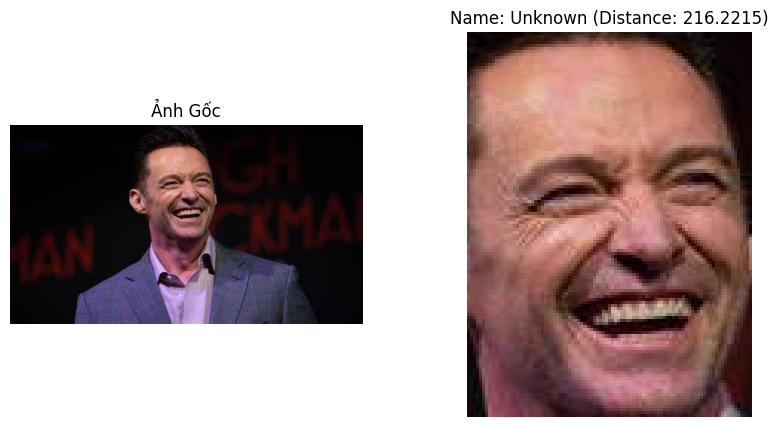

In [ ]:
# Import các thư viện cần thiết
import os
import numpy as np
from scipy.spatial.distance import euclidean
from keras.models import load_model
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from mtcnn import MTCNN

# Đường dẫn mô hình và cơ sở dữ liệu
MODEL_PATH = "models/siamese_model.h5"
DATABASE_PATH = "data/database_embeddings.npy"
RAW_DIR = "data/raw"

# Kiểm tra tệp mô hình và cơ sở dữ liệu
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Mô hình không tìm thấy tại: {MODEL_PATH}")
if not os.path.exists(DATABASE_PATH):
    raise FileNotFoundError(f"Cơ sở dữ liệu không tìm thấy tại: {DATABASE_PATH}")

# Load mô hình và cơ sở dữ liệu
print("Đang tải mô hình và cơ sở dữ liệu...")
siamese_model = load_model(MODEL_PATH)
base_model = siamese_model.layers[2]  # Lớp trích xuất đặc trưng
database = np.load(DATABASE_PATH, allow_pickle=True).item()
print("Tải thành công!")

# Khởi tạo MTCNN
detector = MTCNN()

# Hàm phát hiện và cắt khuôn mặt
def detect_and_crop_face(image_path):
    """
    Phát hiện và cắt khuôn mặt từ ảnh gốc.
    Args:
        image_path (str): Đường dẫn ảnh gốc.
    Returns:
        Image: Ảnh đã được cắt khuôn mặt hoặc None nếu không tìm thấy khuôn mặt.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        faces = detector.detect_faces(image_np)
        
        if len(faces) > 0:
            # Chọn khuôn mặt đầu tiên
            face = faces[0]
            x, y, w, h = face['box']
            cropped_face = image.crop((x, y, x + w, y + h))
            return cropped_face
        else:
            print(f"Không tìm thấy khuôn mặt trong ảnh: {image_path}")
            return None
    except Exception as e:
        print(f"Lỗi khi phát hiện khuôn mặt: {e}")
        return None


# Hàm load và chuẩn hóa ảnh
def preprocess_image(image, target_size=(160, 160)):
    """
    Chuẩn hóa ảnh đã được cắt khuôn mặt.
    Args:
        image (PIL.Image): Ảnh đã cắt khuôn mặt.
        target_size (tuple): Kích thước đích.
    Returns:
        np.ndarray: Ảnh đã chuẩn hóa.
    """
    try:
        image = image.resize(target_size)
        image = np.array(image) / 255.0  # Chuẩn hóa pixel về [0, 1]
        return np.expand_dims(image, axis=0)
    except Exception as e:
        raise ValueError(f"Lỗi khi chuẩn hóa ảnh: {e}")


# Hàm nhận diện người trong ảnh
def predict_person(image_path, database, base_model, threshold=0.5):
    """
    Dự đoán tên người trong ảnh bằng cách so sánh đặc trưng với cơ sở dữ liệu.
    Args:
        image_path (str): Đường dẫn ảnh cần nhận diện.
        database (dict): Cơ sở dữ liệu embeddings. {"name": [embedding1, embedding2, ...]}.
        base_model (Model): Mô hình trích xuất đặc trưng từ ảnh.
        threshold (float): Ngưỡng để quyết định nhận diện.
    Returns:
        str: Tên người nếu nhận diện được, hoặc "Unknown".
        float: Khoảng cách nhỏ nhất từ ảnh đến cơ sở dữ liệu.
    """
    try:
        cropped_face = detect_and_crop_face(image_path)
        if cropped_face is None:
            return "No Face Detected", float('inf')

        image = preprocess_image(cropped_face)
        embedding = base_model.predict(image).flatten()

        closest_person = None
        min_distance = float('inf')

        for person_name, embeddings in database.items():
            for db_embedding in embeddings:
                db_embedding = db_embedding.flatten()
                distance = euclidean(embedding, db_embedding)
                if distance < min_distance:
                    min_distance = distance
                    closest_person = person_name

        if min_distance < threshold:
            return closest_person, min_distance
        else:
            return "Unknown", min_distance
    except Exception as e:
        print(f"Lỗi khi nhận diện người trong ảnh: {e}")
        return "Error", float('inf')


# Hàm hiển thị kết quả
def display_result(image_path, cropped_face, person, distance):
    """
    Hiển thị ảnh và thông tin người nhận diện.
    Args:
        image_path (str): Đường dẫn ảnh.
        cropped_face (PIL.Image): Ảnh đã cắt khuôn mặt.
        person (str): Tên người nhận diện hoặc "Unknown".
        distance (float): Khoảng cách nhỏ nhất.
    """
    try:
        image = Image.open(image_path)
        plt.figure(figsize=(10, 5))

        # Hiển thị ảnh gốc
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Ảnh Gốc")
        plt.axis("off")

        # Hiển thị khuôn mặt
        plt.subplot(1, 2, 2)
        if cropped_face:
            plt.imshow(cropped_face)
            plt.title(f"Name: {person} (Distance: {distance:.4f})")
        else:
            plt.title("Không tìm thấy khuôn mặt")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Lỗi khi hiển thị ảnh: {e}")


# Liệt kê ảnh trong thư mục raw
raw_images = [os.path.join(root, file)
              for root, _, files in os.walk(RAW_DIR)
              for file in files if file.endswith(('.jpg', '.png'))]

print(f"Tìm thấy {len(raw_images)} ảnh trong thư mục raw.")
for idx, img in enumerate(raw_images):
    print(f"{idx + 1}: {img}")

# Yêu cầu người dùng nhập chỉ số ảnh
try:
    idx = int(input("Nhập chỉ số ảnh để nhận diện (1, 2, ...): ")) - 1
    if idx < 0 or idx >= len(raw_images):
        raise ValueError("Chỉ số ảnh không hợp lệ.")

    test_image_path = raw_images[idx]
    print(f"Nhận diện ảnh: {test_image_path}")

    # Nhận diện người trong ảnh
    cropped_face = detect_and_crop_face(test_image_path)
    person, distance = predict_person(test_image_path, database, base_model, threshold=0.5)

    # In kết quả
    print(f"Người được nhận diện: {person}")
    print(f"Khoảng cách: {distance:.4f}")

    # Hiển thị kết quả
    display_result(test_image_path, cropped_face, person, distance)

except ValueError as ve:
    print(f"Lỗi nhập liệu: {ve}")
except Exception as e:
    print(f"Lỗi khác: {e}")
